In [15]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from PIL import Image

## Introduction
This notebook explores the MRI image dataset to understand it's structure and properties, as well as to identify any issues before training on it.

Goals:
1. Organize data and labels
2. Inspect image properties
3. Review and perform sanity checks

This is all about getting familiar with the data we will be working with.

## Data Download
There are scripts provided that will download the data from Kaggle, flatten the directories to make the data easier to work with, and create a `labels.csv` file that maps every image with the appropriate label (normal vs. sick). Some scripts use the Kaggle API, so make sure that is set up on your machine before running anything. Lastly, run the scripts from the root directory of the project.

1. Run `src/data/download_data.py` to download the dataset from Kaggle.
2. Run `src/data/flatten_data.py` to cleanly organize the data under simple directories.
3. Run `src/data/create_labels.py` to create the `labels.csv` file.

After executing these scripts, the images should be available in the `data/` folder.
We can preview the labels file generated with the code block below.

In [16]:
# Preview labels.csv
PROJECT_PATH = os.path.dirname(os.path.abspath('__file__'))
LABELS_PATH = os.path.join(PROJECT_PATH, '..', 'data', 'labels.csv')
labels_df = pd.read_csv(LABELS_PATH)
labels_df.head()

,filename,label
0,flat/normal/Normal_Directory_10_series0003-Bod...,normal
1,flat/normal/Normal_Directory_9_series0072-Body...,normal
2,flat/normal/Normal_Directory_10_series0025-Bod...,normal
3,flat/normal/Normal_Directory_5_series0043-Body...,normal
4,flat/normal/Normal_Directory_5_series0083-Body...,normal


### Class Distribution
We want to examine the distribution of the data we have to ensure there is a balance between the two categories. An imbalanced dataset can lead to a biased model. A bar chart can quickly give insight of the distribution between the categories.

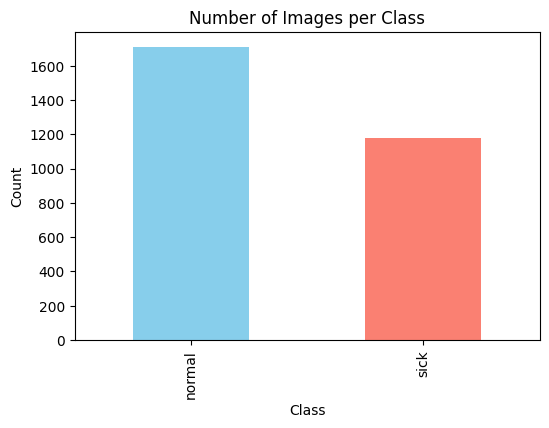

The proportion of normal images is: 0.5917732457656412
The proportion of sick images is: 0.4082267542343588


In [17]:
# Display bar graph
class_counts = labels_df['label'].value_counts()
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display ratios
total_images = class_counts.values.item(0) + class_counts.values.item(1)
proportion_normal = class_counts.values.item(0) / total_images
proportion_sick = class_counts.values.item(1) / total_images
print('The proportion of normal images is:', proportion_normal)
print('The proportion of sick images is:', proportion_sick)

### Visual Inspection
We want to view a few random samples of the images for quality and to get a feel of the variability between the images. Run the code block below to get a random sample of images.

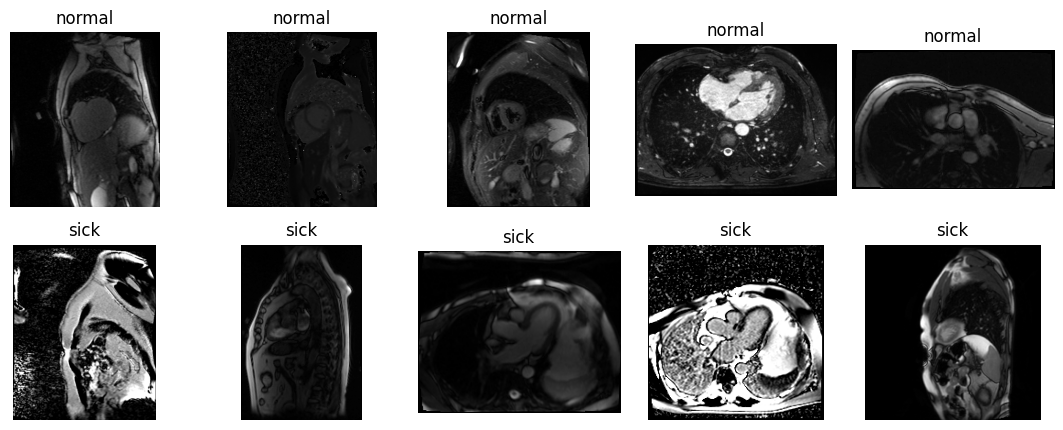

In [22]:
# Preview 5 normal and 5 sick images
samples_per_class = 5
classes = labels_df['label'].unique().tolist()

fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class*2.2, len(classes)*2.2))
if len(classes) == 1:
    axes = axes[np.newaxis, :]  # keep indexing consistent

for i, cls in enumerate(classes):
    sample_filenames = labels_df[labels_df['label'] == cls]['filename'].sample(samples_per_class, random_state=42).tolist()
    sample_paths = [os.path.join(PROJECT_PATH, '..', 'data', fname) for fname in sample_filenames]
    for j, p in enumerate(sample_paths):
        img = Image.open(p)
        ax = axes[i, j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(cls)
plt.tight_layout()
plt.show()

### Image Metadata
Now we want to analyze the metadata for these images to understand their structure. Extracting the **width**, **height**, and **aspect ratio** for these images will help us identify variations in the dataset. This can help us decide if preprocessing and normalization of the images are needed before training.

  label  width  height  aspect_ratio
0  sick    240     240      1.000000
1  sick    512     416      1.230769
2  sick    218     256      0.851562
3  sick    512     416      1.230769
4  sick    240     240      1.000000


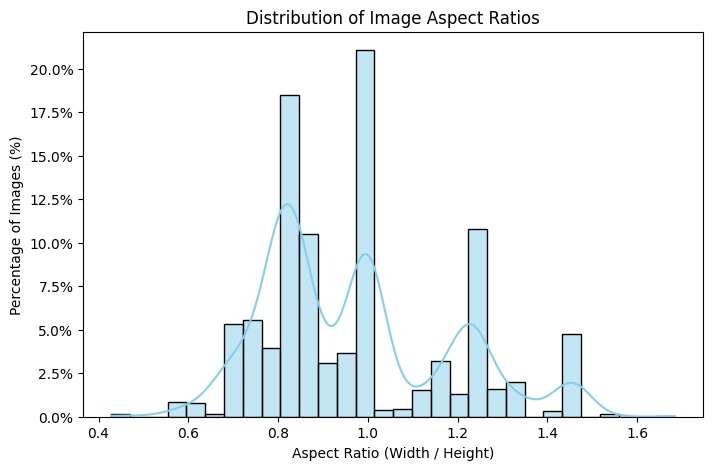

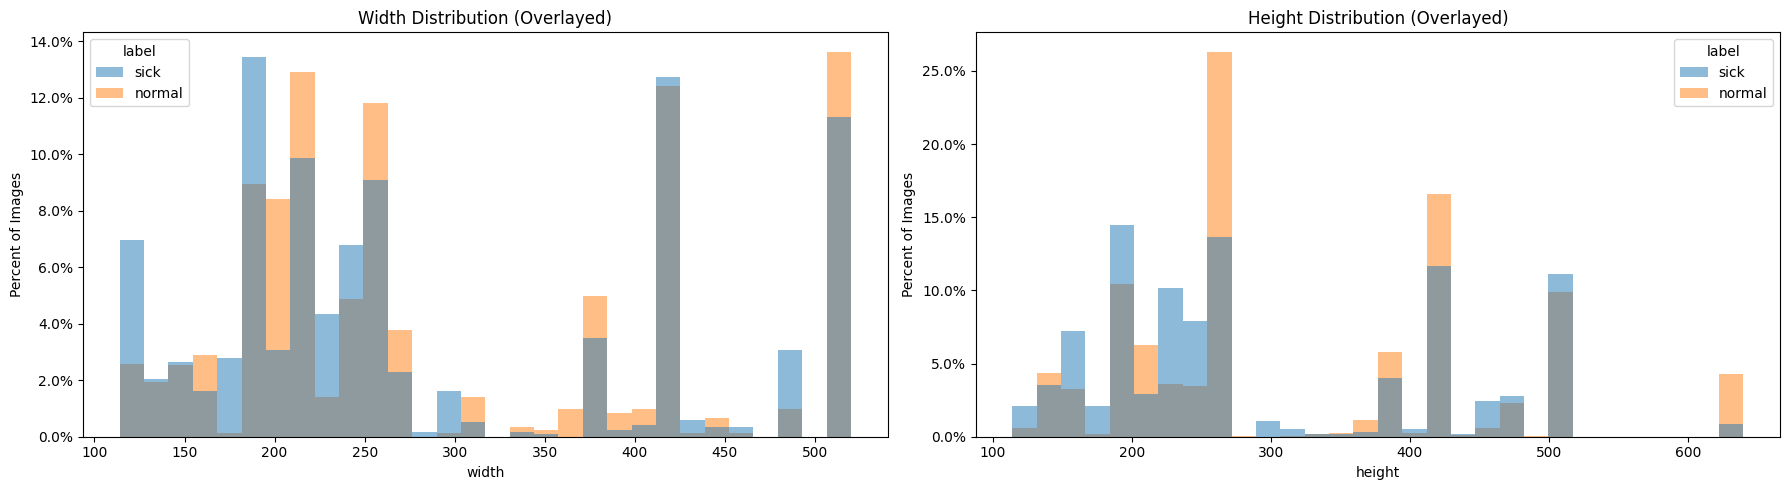

In [20]:
DATA_DIR = "../data/flat"
valid_ext = '.jpg'

# Collect metadata
metadata = []
for label in os.listdir(DATA_DIR):
    LABEL_PATH = os.path.join(DATA_DIR, label)
    if not os.path.isdir(LABEL_PATH):
        continue
    
    for filename in os.listdir(LABEL_PATH):
        if not filename.lower().endswith(valid_ext):
            continue
        filepath = os.path.join(LABEL_PATH, filename)
        try:
            with Image.open(filepath) as img:
                width, height = img.size
                aspect_ratio = width / height
                metadata.append({
                    "label": label,
                    "width": width,
                    "height": height,
                    "aspect_ratio": aspect_ratio
                })
        except Exception as e:
            print(f"Error reading {filepath}: {e}")

# Create DataFrame
df_meta = pd.DataFrame(metadata)
print(df_meta.head())

# Plot Ascpect Ratio histogram
aspect_ratios = [meta['width'] / meta['height'] for meta in metadata]

plt.figure(figsize=(8, 5))
sns.histplot(aspect_ratios, bins=30, kde=True, stat='probability', color='skyblue')

plt.title("Distribution of Image Aspect Ratios")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Percentage of Images (%)")

# Convert y-axis to percentages
y_vals = plt.gca().get_yticks()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Width histogram
sns.histplot(
    data=df_meta,
    x='width',
    hue='label',
    bins=30,
    stat='probability',   # normalize to percentages
    common_norm=False,    # don't force normalization across groups
    alpha=0.5,            # transparency so both classes are visible
    edgecolor=None,
    ax=axes[0]
)
axes[0].set_title('Width Distribution (Overlayed)')
axes[0].yaxis.set_major_formatter(PercentFormatter(1))
axes[0].set_ylabel('Percent of Images')

# Height histogram
sns.histplot(
    data=df_meta,
    x='height',
    hue='label',
    bins=30,
    stat='probability',
    common_norm=False,
    alpha=0.5,
    edgecolor=None,
    ax=axes[1]
)
axes[1].set_title('Height Distribution (Overlayed)')
axes[1].yaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_ylabel('Percent of Images')

plt.tight_layout()
plt.show()

The distribution looks to have many peaks, but the overlap between labels seems uniformed. Taking the medians for the heights and widths should give us an idea of our target size for normalization.

In [21]:
# Calculate target size
target_w = int(np.median(df_meta['width']))
target_h = int(np.median(df_meta['height']))
print(f'Suggested target size: ({target_w}, {target_h})')

Suggested target size: (256, 256)


### Conclusion
The dataset consists of Normal and Sick images, with a pretty balanced distribution between the labels. The image previews confirmed the data loaded correctly and contains appropriate files pertaining to CAD classification. Although there are many peaks in the histograms, it does show that the overlap between labels are consistent. We conclude that we can resize to a common image shape without introducing bias.